# Tests of WMRB
Try out Weighted Margin Batch Loss to see if I understand it

In [15]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib import collections, lines, markers, path, patches
%matplotlib inline

In [16]:
from optimiser import *

In [17]:
def sigmoid(x):
    return 1./(1+np.exp(-x))

In [18]:
def rank(x, y, ybar, norm_y, geometry="spherical"):
    '''
        Calculate rank following WMRB paper, but don't do mini-batches here.
        Inputs: f, function used to define ranking (a distance here)
                x, user vector (1-D np.array)
                y, positive item vector (1-D np.array)
                ybar, list of negative item vectors
                norm_y, norm of Y, the set of all item vectors
                geometry: string specifying geometry to use
        Outputs: rank of positive item, y
        
        Notes: vectorise later
    '''
    sum_marg_err = 0
    norm_yneg = 0
    for yneg in ybar:
        norm_yneg += 1 #Assume |.| is sum of norms, otherwise I'd get zero on sphere...
        #Assume closer is better, so take negative distance as function
        marg_err = np.max(1 + distance(x, y, geometry) - distance(x, yneg, geometry), 0)
        sum_marg_err += 2.*sigmoid(marg_err)-1
    rank = (norm_y/norm_yneg)*sum_marg_err
    return rank

## Sphere test
Start with one positive and one negative example, and a fixed user vector.

In [19]:
alpha = 0.1
beta = 1.1
a = np.array([np.cos(alpha), np.sin(alpha)])
b = np.array([np.cos(beta), np.sin(beta)])
positives = [a]
negatives = [b]
users = [np.array([np.cos(2.5), np.sin(2.5)]), -np.array([np.cos(2.5), np.sin(2.5)])]

In [20]:
print(rank(users[0], a, negatives, 2.))
print(rank(users[0], b, positives, 2.))

1.5231883119115293
0.0


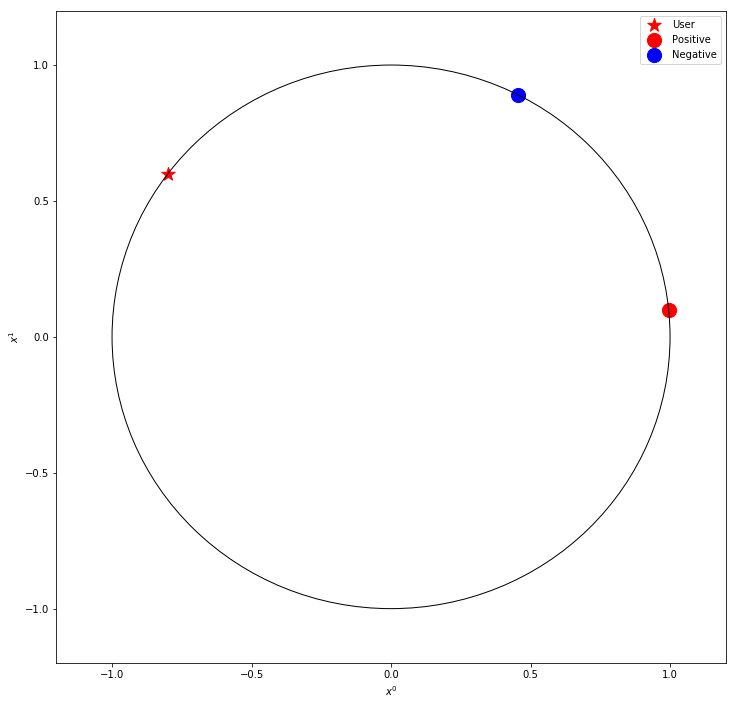

In [21]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
ax.add_artist(circle)
ax.scatter(users[0][0], users[0][1], color='r', marker='*',s=200,label = "User")
ax.scatter(a[0], a[1], color='r', marker='o',s=200,label = "Positive")
ax.scatter(b[0], b[1], color='b', marker='o',s=200,label = "Negative")
ax.legend()

In [22]:
def gradient(x, y, ybar, norm_y, geometry="spherical"):
    '''
        Evaluate gradient of ranking loss with respect to the positive item vector
        Inputs: x: the user vector
                y: the positive item vector
                ybar: list of negative item vectors
                norm_y: norm of Y, the set of all item vectors
                geometry: string specifying geometry to use    '''
    rank_y = rank(x, y, ybar, norm_y, geometry="spherical")
    dot_xy = dot(x, y, geometry)
    sig_s = sigmoid(distance(x, y, geometry))
    grad = -(1./(1+rank_y))*2*sig_s*(1-sig_s)
    if geometry == "spherical":
        grad /= np.sqrt(1.-dot(x, y)**2)
    elif geometry == "hyperbolic":
        grad /= np.sqrt(dot(x, y)**2 - 1.)
    else:
        print("geometry = {} is not a valid option! Try 'spherical' or 'hyperbolic'".format(geometry))    
        
    return grad * get_metric(x.shape[0], geometry).dot(x)

In [23]:
def gradient_descent_wmrb(
                        y, x, ybar, norm_y, 
                        differential_fn,
                        geometry="hyperbolic",
                        learning_rate=1.,
                        return_vectors=False,
                        test_rel_correction=False,
                    ):
    '''
        Calculate local gradient of differential, given the current pt and the target.
        Inputs:
                Two (d+1)-dimensional vectors in ambient space co-ordinates, pt_i and target
                pt_i: (d+1)-dimensional vector in ambient space co-ordinates,
                       the point to evaluate the gradient at.
                target: (d+1)-dimensional vectors in ambient space co-ordinates, the target point
                differential_fn: function that calculates the derivative
                learning_rate: dictates how far to step in gradient direction
    '''
#    print("gradient_descent({},{},{},{},{},{},{}):".format(
#                type(pt_i), type(target), differential_fn, geometry, learning_rate, return_vectors, test_rel_correction
#            )
#         )
    # Calculate gradient in ambient space co-ordinates
    step = differential_fn(x, y, ybar, norm_y, geometry)
#    print("gradient_descent: step =",step)
    # Project this gradient onto tangent space
    projection = project_to_tangent(y, step, geometry)
#    print("gradient_descent: projection on tangent space = ",projection)
    # Map to manifold and return this updated pt
    if return_vectors:
        return (
                    exponential_map(-learning_rate*projection, y, geometry),
                    step,
                    projection,
                )
    else:
        return exponential_map(-learning_rate*projection, y, geometry)

In [24]:
updated_pts = [positives[0]]
for i in range(1,20):
    updated_pts.append(
        gradient_descent_wmrb(updated_pts[i-1], 
                         users[0],
                         negatives,
                         2,
                         gradient, 
                         geometry="spherical", 
                         learning_rate=1.,
                        )

    )
print(updated_pts)

project_to_tangent: point_on_manifold = [0.99500417 0.09983342], displacement = [ 0.0716898  -0.05355388], geometry = spherical
project_to_tangent: point_on_manifold = [0.98715655 0.1597559 ], displacement = [ 0.07156847 -0.05346324], geometry = spherical
project_to_tangent: point_on_manifold = [0.97487137 0.22276853], displacement = [ 0.07199607 -0.05378267], geometry = spherical
project_to_tangent: point_on_manifold = [0.95734615 0.28894351], displacement = [ 0.07302498 -0.05455129], geometry = spherical
project_to_tangent: point_on_manifold = [0.93360605 0.3583012 ], displacement = [ 0.07474253 -0.05583434], geometry = spherical
project_to_tangent: point_on_manifold = [0.90245769 0.43077851], displacement = [ 0.07728424 -0.05773305], geometry = spherical
project_to_tangent: point_on_manifold = [0.86242804 0.50617968], displacement = [ 0.08085627 -0.06040144], geometry = spherical
project_to_tangent: point_on_manifold = [0.81168277 0.58409852], displacement = [ 0.08577473 -0.06407564

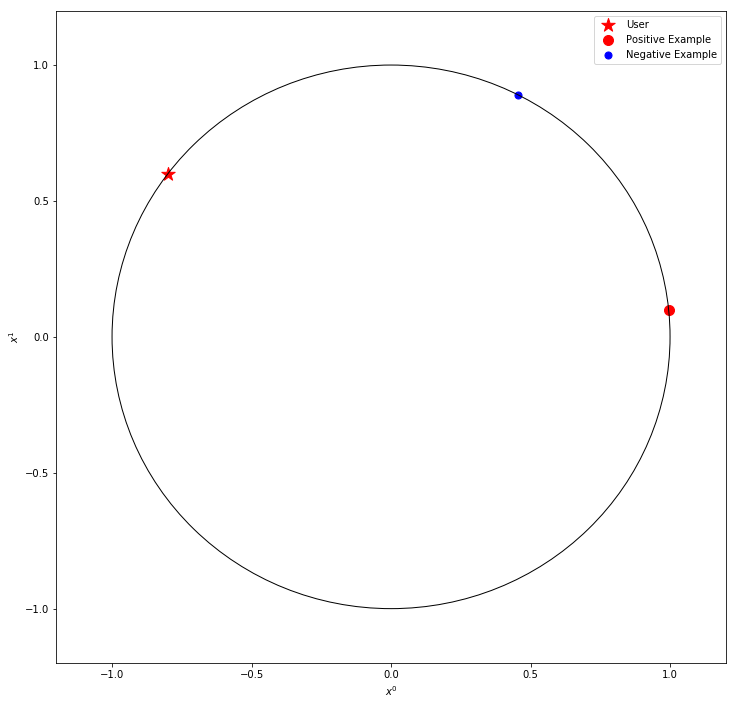

In [25]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)
ax.scatter(users[0][0], users[0][1], color='r', marker='*',s=200,label = "User")
pos_scat = ax.scatter([], [], color='r', marker = 'o', s = 100, label = "Positive Example")
ax.scatter(negatives[0][0], negatives[0][1], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()
#fig.canvas.draw()
bg_cache = fig.canvas.copy_from_bbox(ax.bbox)

def plot_point(num):
    pos_scat.set_offsets(updated_pts[num])
    return pos_scat
#    return updated_pts[num]

anim = animation.FuncAnimation(fig,
                               plot_point,
                   #            gradient_descent(
                   #                              updated_pts[i-1], 
                   #                              users[0], 
                   #                              error_differential_eucl, 
                    #                             geometry="spherical", 
                   #                              learning_rate=0.2
                    #            ),
                               frames=len(updated_pts),
                               blit=False,
                              )
anim.save('circle.mp4')

## Now try with users that are the sum of the products

project_to_tangent: point_on_manifold = [ 0.98163203 -0.19078409], displacement = [99.02897056 11.07230648], geometry = spherical
project_to_tangent: point_on_manifold = [-0.95794332  0.28695747], displacement = [-27.48248038   5.46872563], geometry = spherical
project_to_tangent: point_on_manifold = [-0.41916327  0.90791087], displacement = [ 5.88245081 21.3667503 ], geometry = spherical
project_to_tangent: point_on_manifold = [0.95676087 0.29087564], displacement = [136.21324618  56.4326088 ], geometry = spherical
project_to_tangent: point_on_manifold = [-0.31517132  0.94903479], displacement = [-17.62894879  57.33855796], geometry = spherical
project_to_tangent: point_on_manifold = [-0.68145708  0.73185808], displacement = [-16.52724273  44.00428143], geometry = spherical
project_to_tangent: point_on_manifold = [-0.19065072  0.98165794], displacement = [-2.26828393 32.22597728], geometry = spherical
project_to_tangent: point_on_manifold = [-0.99214036  0.12512994], displacement = [1

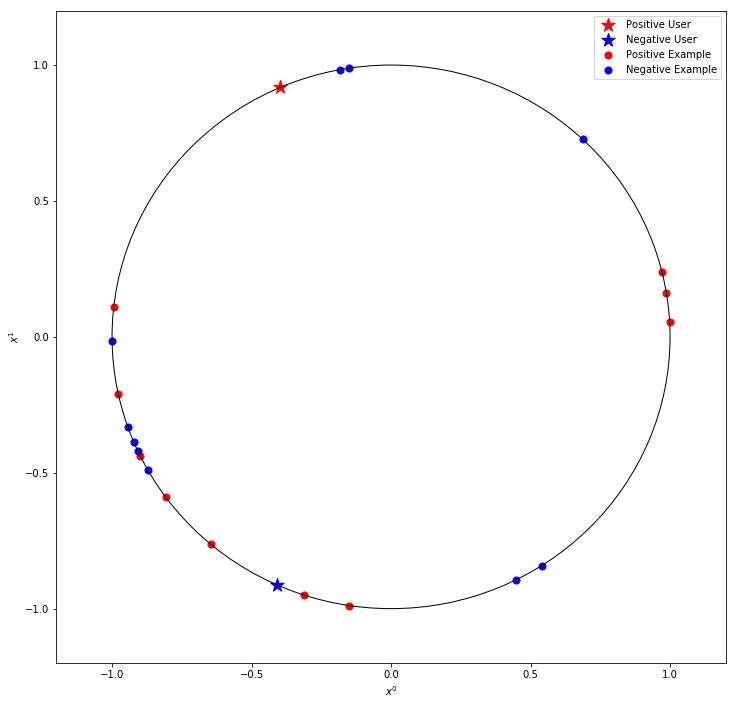

In [26]:
np.random.seed(1221)
user_angle = np.random.uniform(-np.pi, np.pi,2)
pos_angle = np.random.uniform(-np.pi, np.pi,10)
neg_angle = np.random.uniform(-np.pi, np.pi,10)
users = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in user_angle])
positives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in pos_angle])
negatives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in neg_angle])
items = [positives, negatives]

for i in range(2):
    for j in range(4):
        users[i] = gradient_descent(
                             users[i], 
                             items[i], 
                             frechet_diff, 
                             geometry="spherical", 
                             learning_rate=0.32,
                             return_vectors=False,
                        )

fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)
ax.scatter(users[0][0], users[0][1], color='r', marker='*',s=200,label = "Positive User")
ax.scatter(users[1][0], users[1][1], color='b', marker='*',s=200,label = "Negative User")
ax.scatter(positives[:,0], positives[:,1], color='r', marker='.',s=200,label = "Positive Example")
ax.scatter(negatives[:,0], negatives[:,1], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()


In [36]:
def loss(users_itemids, all_items, q, geometry="spherical"):
    '''
        Calculate the suppressed margin rank loss
        Input: 
                users_items: dict, keys: users, values: list of positive items
                all_items: list of all items
                q: sampling fraction
                geometry: specify the geometry
        Output:
                loss: a number
        Note: should vectorise
    '''
    sum_loss = 0.
    for user_id, items in users_items.items():
        x = items[0]
        for y in items:
            ybar = np.random.choice(all_items, q*len(all_items), replace=False)
            ybar = set(ybar) - set(y)
            r_y = rank(x, y, ybar, len(all_items), geometry)
            sum_loss += 1.
        

In [42]:
print(np.vstack([positives, negatives]))

[[-0.31035358 -0.95062119]
 [-0.99395486  0.10978954]
 [-0.89834175 -0.43929729]
 [ 0.99845679  0.05553404]
 [ 0.9707366   0.24014674]
 [ 0.9867707   0.1621221 ]
 [-0.80785583 -0.58938015]
 [-0.64669184 -0.76275137]
 [-0.15097606 -0.98853742]
 [-0.97751661 -0.21085844]
 [-0.94355961 -0.33120275]
 [-0.15136238  0.98847834]
 [-0.92181852 -0.38762174]
 [-0.8724617  -0.4886825 ]
 [-0.18357726  0.98300529]
 [ 0.54020896 -0.84153091]
 [ 0.68728328  0.72638949]
 [ 0.4465271  -0.89477011]
 [-0.99989619 -0.0144084 ]
 [-0.90768724 -0.41964732]]


In [48]:
users = {0:[i for i in range(10)], 1:[i for i in range(10, 20)]}
print(users)
neg_examples = set(i for i in range(20)) - set(users[1])
print(neg_examples)

{0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 1: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [32]:
loss({1:(users[0],positives), 2:(users[1], negatives)}, positives+negatives)

[-0.3974021   0.91764458]
[-0.410266  -0.9119659]


## Multiple examples
Now have multiple positive and negative examples

In [ ]:
np.random.seed(121)
pos_angle = np.random.uniform(-np.pi, np.pi,10)
neg_angle = np.random.uniform(-np.pi, np.pi,10)
positives = np.cos(pos_angle)
positives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in pos_angle])
negatives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in neg_angle])

fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)
ax.scatter(users[0][0], users[0][1], color='r', marker='*',s=200,label = "User")
ax.scatter(positives[:,0], positives[:,1], color='r', marker='.',s=200,label = "Positive Example")
ax.scatter(negatives[:,0], negatives[:,1], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()


In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)

ax.scatter(users[0][0], users[0][1], color='r', marker='*',s=200,label = "Positive User")
ax.scatter(users[1][0], users[1][1], color='b', marker='*',s=200,label = "Negative User")
pos_scat = ax.scatter([], [], color='r', marker='.',s=200,label = "Positive Example")
neg_scat = ax.scatter([], [], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()

bg_cache = fig.canvas.copy_from_bbox(ax.bbox)
pos_pts = positives
neg_pts = negatives
def plot_points(num):
    for i, pt in enumerate(pos_pts):
        pos_pts[i] = gradient_descent(
                                             pt, 
                                             users[0], 
                                             error_differential_eucl, 
                                             geometry="spherical", 
                                             learning_rate=0.2
                            )
    pos_scat.set_offsets(pos_pts)
    for i, pt in enumerate(neg_pts):
        neg_pts[i] = gradient_descent(
                                             pt, 
                                             users[1], 
                                             error_differential_eucl, 
                                             geometry="spherical", 
                                             learning_rate=0.2
                            )
    neg_scat.set_offsets(neg_pts)
    return pos_scat, neg_scat
#    return updated_pts[num]

anim = animation.FuncAnimation(fig,
                               plot_points,
                   #            gradient_descent(
                   #                              updated_pts[i-1], 
                   #                              users[0], 
                   #                              error_differential_eucl, 
                    #                             geometry="spherical", 
                   #                              learning_rate=0.2
                    #            ),
                           #    fargs=[updated_pts],
                               frames=20,
                               blit=False,
                              )
anim.save('circle_many.mp4')

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)
pos_user = ax.scatter([],[], color='r', marker='*',s=200,label = "Positive User")
neg_user = ax.scatter([],[], color='b', marker='*',s=200,label = "Negative User")
pos_scat = ax.scatter([], [], color='r', marker='.',s=200,label = "Positive Example")
neg_scat = ax.scatter([], [], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()

bg_cache = fig.canvas.copy_from_bbox(ax.bbox)
pos_pts = positives
neg_pts = negatives
def plot_points(num):
    for i, pt in enumerate(pos_pts):
        pos_pts[i] = gradient_descent(
                                             pt, 
                                             users[0], 
                                             error_differential_eucl, 
                                             geometry="spherical", 
                                             learning_rate=0.2
                            )
    pos_scat.set_offsets(pos_pts)
    for j in range(2):
        users[0] = gradient_descent(
                             users[0], 
                             pos_pts, 
                             frechet_diff, 
                             geometry="spherical", 
                             learning_rate=0.05,
                             return_vectors=False,
                        ) 
    pos_user.set_offsets(users[0])

    for i, pt in enumerate(neg_pts):
        neg_pts[i] = gradient_descent(
                                             pt, 
                                             users[1], 
                                             error_differential_eucl, 
                                             geometry="spherical", 
                                             learning_rate=0.2
                            )
    neg_scat.set_offsets(neg_pts)
    for j in range(2):
        users[1] = gradient_descent(
                             users[1], 
                             neg_pts, 
                             frechet_diff, 
                             geometry="spherical", 
                             learning_rate=0.05,
                             return_vectors=False,
                        )
    neg_user.set_offsets(users[1])
    return pos_scat, neg_scat, pos_user, neg_user
#    return updated_pts[num]

anim = animation.FuncAnimation(fig,
                               plot_points,
                   #            gradient_descent(
                   #                              updated_pts[i-1], 
                   #                              users[0], 
                   #                              error_differential_eucl, 
                    #                             geometry="spherical", 
                   #                              learning_rate=0.2
                    #            ),
                           #    fargs=[updated_pts],
                               interval=1000,
                               frames=20,
                               blit=False,
                              )
anim.save('circle_many_frechet.mp4')

In [ ]:
np.random.seed(1221)
user_angle = np.random.uniform(-np.pi, np.pi,2)
pos_angle = np.random.uniform(-np.pi, np.pi,10)
neg_angle = np.random.uniform(-np.pi, np.pi,10)
users = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in user_angle])
positives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in pos_angle])
negatives = np.array([np.array([np.cos(angle), np.sin(angle)]) for angle in neg_angle])
items = [positives, negatives]

for i in range(2):
    for j in range(4):
        users[i] = gradient_descent(
                             users[i], 
                             items[i], 
                             frechet_diff, 
                             geometry="spherical", 
                             learning_rate=0.32,
                             return_vectors=False,
                        )
        
fig = plt.figure(figsize=(12,12))
ax = plt.gca(xlim=[-1.2, 1.2], ylim=[-1.2,1.2], xlabel="$x^0$", ylabel="$x^1$")
circle = patches.Circle((0,0), 1., edgecolor="k", fill=False)
#ax.add_collection(collections.PatchCollection(patch_list))
ax.add_artist(circle)
pos_user = ax.scatter([],[], color='r', marker='*',s=200,label = "Positive User")
neg_user = ax.scatter([],[], color='b', marker='*',s=200,label = "Negative User")
pos_scat = ax.scatter([], [], color='r', marker='.',s=200,label = "Positive Example")
neg_scat = ax.scatter([], [], color='b', marker='.',s=200,label = "Negative Example")
ax.legend()

bg_cache = fig.canvas.copy_from_bbox(ax.bbox)
pos_pts = positives
neg_pts = negatives
def plot_points(num):
    for i, pt in enumerate(pos_pts):
        pos_pts[i] = gradient_descent(
                                             pt, 
                                             users[0], 
                                             error_differential_eucl, 
                                             geometry="spherical", 
                                             learning_rate=0.2
                            )
    pos_scat.set_offsets(pos_pts)
    for j in range(4):
        users[0] = gradient_descent(
                             users[0], 
                             pos_pts, 
                             frechet_diff, 
                             geometry="spherical", 
                             learning_rate=0.2,
                             return_vectors=False,
                        ) 
    pos_user.set_offsets(users[0])
    print('-'*80)
    return pos_scat, pos_user
#    return updated_pts[num]

anim = animation.FuncAnimation(fig,
                               plot_points,
                   #            gradient_descent(
                   #                              updated_pts[i-1], 
                   #                              users[0], 
                   #                              error_differential_eucl, 
                    #                             geometry="spherical", 
                   #                              learning_rate=0.2
                    #            ),
                           #    fargs=[updated_pts],
                               interval=1000,
                               frames=4,
                               blit=False,
                              )
anim.save('circle_many_frechet2.mp4')